# Fit energies and forces (full cycle)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.expandvars("/home/$USER/repos/fande/"))

In [55]:
from ase import io

traj_295 = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index=":")
traj_355 = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_355K/md_trajectory.traj", index=":")

traj_295_2000K = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_2000K/md_trajectory.traj", index=":")
traj_355_2000K = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_2000K/md_trajectory.traj", index=":")
traj_295_2000K_forced = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_2000K_0075force/md_trajectory.traj", index=":")
traj_355_2000K_forced = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_2000K_0075force/md_trajectory.traj", index=":")


In [56]:
from fande.data import FandeDataModule
from fande.utils.find_atomic_groups import find_atomic_groups

fdm = FandeDataModule()

In [64]:
trajectory_forces = traj_295_2000K[0:5000:10]
trajectory_forces = trajectory_forces.copy()
trajectory_energy = traj_295[0:5000:10] + traj_355[0:5000:10] + traj_295_2000K[0:5000:10] + traj_355_2000K[0:5000:10] + traj_295_2000K_forced[0:5000:10] + traj_355_2000K_forced[0:5000:10]
trajectory_energy = trajectory_energy[0:10].copy()

In [65]:
soap_params = dict(soap_type="PowerSpectrum",
        interaction_cutoff=3.0,
        max_radial=3,
        max_angular=3,
        gaussian_sigma_constant=0.3,
        gaussian_sigma_type="Constant",
        cutoff_function_type="RadialScaling",
        cutoff_smooth_width=0.1, # 0.1 is way better than 0.5
        cutoff_function_parameters=
                dict(
                        rate=1,
                        scale=3.5,
                        exponent=4
                        ),
        radial_basis="GTO",
        normalize=True, # setting False makes model untrainable
        #   optimization=
        #         dict(
        #                 Spline=dict(
        #                    accuracy=1.0e-05
        #                 )
        #             ),
        compute_gradients=True, # for energies gradients are ignored
        expansion_by_species_method='structure wise'
        )
##FOR NOW USE THE SAME SOAP PARAMETERS FOR ENERGY AND FORCES!

sample_snapshot = trajectory_forces[0].copy()
fdm = FandeDataModule()
atomic_groups = find_atomic_groups(sample_snapshot)
train_centers_positions = sum(atomic_groups, []) #list(range(len(atoms)))
train_derivatives_positions = sum(atomic_groups, [])#list(range(len(atoms)))
fdm.atomic_groups_sample_snapshot = sample_snapshot.copy()
fdm.atomic_groups = atomic_groups

total_forces_samples_per_group = [3000] * len(atomic_groups)
high_forces_samples_per_group = [0] * len(atomic_groups)

Total number of found groups: 14
Checking if all atoms are covered:  True


In [66]:
dataloader_energy, dataloaders_forces = fdm.dataloaders_from_trajectory(
                                                                trajectory_energy,
                                                                trajectory_forces,
                                                                # energies = None,
                                                                # forces = None,
                                                                atomic_groups = atomic_groups,
                                                                centers_positions = train_centers_positions,
                                                                derivatives_positions = train_derivatives_positions,
                                                                energy_soap_hypers = soap_params,
                                                                forces_soap_hypers = soap_params,
                                                                total_forces_samples_per_group = total_forces_samples_per_group,
                                                                high_force_samples_per_group = high_forces_samples_per_group,
                                                                )

Total length of traj is 10
Total number of batches 10
Calculating invariants on trajectory with librascal...


100%|██████████| 10/10 [00:00<00:00, 32.74it/s]


energy invariants calculated


100%|██████████| 500/500 [03:58<00:00,  2.09it/s]


Dataloader for group 0 created
Number of samples in dataloader: 3000
Dataloader for group 1 created
Number of samples in dataloader: 3000
Dataloader for group 2 created
Number of samples in dataloader: 3000
Dataloader for group 3 created
Number of samples in dataloader: 3000
Dataloader for group 4 created
Number of samples in dataloader: 3000
Dataloader for group 5 created
Number of samples in dataloader: 3000
Dataloader for group 6 created
Number of samples in dataloader: 3000
Dataloader for group 7 created
Number of samples in dataloader: 3000
Dataloader for group 8 created
Number of samples in dataloader: 3000
Dataloader for group 9 created
Number of samples in dataloader: 3000
Dataloader for group 10 created
Number of samples in dataloader: 3000
Dataloader for group 11 created
Number of samples in dataloader: 3000
Dataloader for group 12 created
Number of samples in dataloader: 3000
Dataloader for group 13 created
Number of samples in dataloader: 3000


In [67]:
# Making energy model

from fande.models import EnergyModel

hparams = {
        'dtype' : 'float32',
        'device' : 'gpu',
        'energy_model_hparams' : {
                'num_epochs' : 200,
                'learning_rate' : 0.1,
        }
        }
       
Energy_model = EnergyModel(
        dataloader_energy,
        hparams=hparams, 
        gpu_id=0)

Energy_model.fit()

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/dlbox2/anaconda3/envs/fande/lib/python3.10/sit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModelEnergy         | 542   
2 | mll        | ExactMarginalLogLikelihood | 542   
----------------------------------------------------------
542       Trainable params
0         Non-trainable params
542       Total params
0.


RawEnergyModel initialized
Training energy model


/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [73]:
%%time
# Fitting forces

from fande.models import ModelForces, GroupModelForces


n_steps_list = [200] * len(atomic_groups)
lr_list = [0.1] * len(atomic_groups)

models_hparams = []
for i in range(len(atomic_groups)):
        model_hparams = {
        'atomic_group' : atomic_groups[i],
        'dtype' : hparams['dtype'],
        'device' : hparams['device'],
        'num_epochs' : n_steps_list[i],
        'learning_rate' : lr_list[i],
        'soap_dim' : dataloaders_forces[i].dataset[0][0].shape[-1],
        'soap_params' : soap_params,
        }
        models_hparams.append(model_hparams)



hparams['per_model_hparams'] = models_hparams # access per_model_hparams by model.model_id
gpu_id = 0


models_forces = []
for i in range(len(atomic_groups)):
        model = ModelForces(
        train_x = dataloaders_forces[i].dataset[:][0],
        train_y = dataloaders_forces[i].dataset[:][1],
        atomic_group = atomic_groups[i],
        hparams = hparams,
        id=i)
        models_forces.append(model)
        
AG_force_model = GroupModelForces(
        models= models_forces,
        train_data_loaders = dataloaders_forces,
        hparams=hparams, 
        gpu_id=gpu_id)

AG_force_model.fit()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avai


ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized

ModelForces initialized


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU avai

Training force model 0 (Total 14 models)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModelForces         | 542   
2 | mll        | ExactMarginalLogLikelihood | 542   
----------------------------------------------------------
542       Trainable params
0         Non-trainable params
542       Total params
0.002     Total estimated model params size (MB)


Training force model 1 (Total 14 models)


Training: 0it [00:00, ?it/s]

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.631535291671753 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.3471163511276245 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-package

Training force model 2 (Total 14 models)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModelForces         | 542   
2 | mll        | ExactMarginalLogLikelihood | 542   
----------------------------------------------------------
542       Trainable params
0         Non-trainable params
542       Total params
0.002     Total estimated model params size (MB)


Training force model 3 (Total 14 models)


Training: 0it [00:00, ?it/s]

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.8607306480407715 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModelForces         | 542   
2 | mll        | ExactMarginalLogLikelihood | 542   
----------------------------------------------------------
542       Trainable params
0         Non-trainable params
542       Total params
0.002     Total estimated

Training force model 4 (Total 14 models)


Training: 0it [00:00, ?it/s]

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5112402439117432 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModelForces         | 542   
2 | mll        | ExactMarginalLogLikelihood | 542   
----------------------------------------------------------
542       Trainable params
0         Non-trainable params
542       Total params
0.002     Total estimated

Training force model 5 (Total 14 models)


Training: 0it [00:00, ?it/s]

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.6308112144470215 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.370994210243225 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 

Training force model 6 (Total 14 models)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModelForces         | 542   
2 | mll        | ExactMarginalLogLikelihood | 542   
----------------------------------------------------------
542       Trainable params
0         Non-trainable params
542       Total params
0.002     Total estimated model params size (MB)


Training force model 7 (Total 14 models)


Training: 0it [00:00, ?it/s]

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.6808009147644043 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.0592358112335205 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK:

Training force model 8 (Total 14 models)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModelForces         | 542   
2 | mll        | ExactMarginalLogLikelihood | 542   
----------------------------------------------------------
542       Trainable params
0         Non-trainable params
542       Total params
0.002     Total estimated model params size (MB)


Training force model 9 (Total 14 models)


Training: 0it [00:00, ?it/s]

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.2109146118164062 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.5580682754516602 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK:

Training force model 10 (Total 14 models)


Training: 0it [00:00, ?it/s]

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.4002044200897217 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.30248761177063 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0

Training force model 11 (Total 14 models)


Training: 0it [00:00, ?it/s]

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.5375235080718994 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 2.6679463386535645 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK:

Training force model 12 (Total 14 models)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                       | Params
----------------------------------------------------------
0 | likelihood | GaussianLikelihood         | 1     
1 | model      | ExactGPModelForces         | 542   
2 | mll        | ExactMarginalLogLikelihood | 542   
----------------------------------------------------------
542       Trainable params
0         Non-trainable params
542       Total params
0.002     Total estimated model params size (MB)


Training force model 13 (Total 14 models)


Training: 0it [00:00, ?it/s]

/home/dlbox2/anaconda3/envs/fande/lib/python3.10/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 3.5987584590911865 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=200` reached.


CPU times: user 5min 50s, sys: 8.04 s, total: 5min 58s
Wall time: 5min 53s


In [74]:
from fande.predict import FandePredictor
from fande.ase import FandeCalc

# Energy_model = None
# AG_force_model = None
predictor = FandePredictor(
        fdm,
        AG_force_model,
        Energy_model,
        hparams,
        soap_params
        )


In [75]:
fande_calc = FandeCalc(predictor)

In [138]:
fande_calc.save_predictor("fande_predictor.pth")

Saving predictor requires humongous amount of memory! Spare some dozens of GBs!


In [127]:
from tqdm import tqdm
test_traj = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="1000:1020")
test_traj = test_traj.copy()

real_energies = [s.get_potential_energy() for s in test_traj]
predicted_energies = []
for i in tqdm(range(20)):
        test_traj[i].set_calculator(fande_calc)
        # predicted_energies.append( test_traj[i].get_potential_energy() )
        # print(test_traj[i].get_potential_energy() )
        test_traj[i].get_forces()
        print(test_traj[i].get_potential_energy() )
        # test_traj[i].get_forces()

[-3093.036]


[-3092.8828]


[-3092.6836]


[-3092.4426]


[-3092.2104]


[-3092.041]


[-3091.895]


[-3091.72]


[-3091.5298]


[-3091.402]


[-3091.4163]


[-3091.5889]


[-3091.884]


[-3092.107]


[-3092.208]


[-3092.3203]


[-3092.4832]


[-3092.6792]


[-3092.8586]


100%|██████████| 20/20 [00:10<00:00,  1.87it/s]

[-3093.0508]


In [106]:
import numpy as np
np.any(True)

True

In [85]:
%%time
# test_traj[0].get_forces()
for i in tqdm(range(len(test_traj))):
        test_traj[i].get_forces()
# test_traj[1].get_potential_energy()

 30%|███       | 6/20 [00:07<00:16,  1.20s/it]


KeyboardInterrupt: 

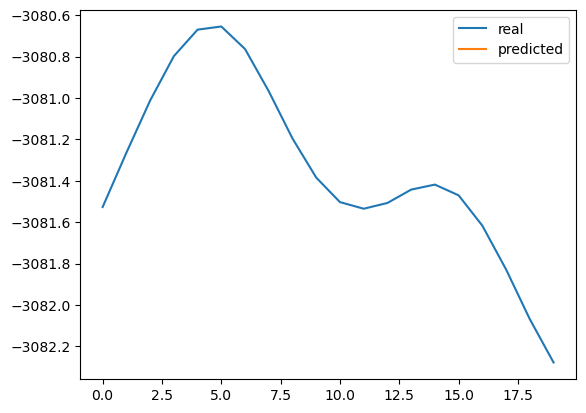

In [137]:
import matplotlib.pyplot as plt

plt.plot(real_energies, label="real")
plt.plot(predicted_energies, label="predicted")
plt.legend()
plt.show()

In [14]:
atoms = trajectory_energy[51].copy()

atoms.set_calculator(fande_calc)

print(atoms.get_potential_energy())
print(atoms.get_forces())

Atomic group force model is not defined. Cannot predict forces. Returning zeros.
[-3080.6099]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [2]:
fande_calc.save_predictor("prrrrr.pt")

NameError: name 'fande_calc' is not defined

In [3]:
import torch
from fande.ase import FandeCalc

predictor_loaded = torch.load("prrrrr.pt")

fande.models module imported...


In [4]:
fande_calc_loaded = FandeCalc(predictor_loaded)

In [6]:
from ase import io
atoms = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="10")

atoms.set_calculator(fande_calc_loaded)

In [1]:
atoms.get_potential_energy()
atoms.get_forces()

NameError: name 'atoms' is not defined

array([[0.00688136, 0.00688136, 0.00688136],
       [0.00688136, 0.00688136, 0.00688136],
       [0.00688136, 0.00688136, 0.00688136],
       ...,
       [0.16884041, 0.16884041, 0.16884041],
       [0.16884041, 0.16884041, 0.16884041],
       [0.16884041, 0.16884041, 0.16884041]])